### Getting dataset ready

In [1]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [4]:
X, y = mnist["data"],mnist["target"]

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### KNN classification

In [10]:
# originally meant to use grid search but takes too much time
# simple knn
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [11]:
# ! takes time
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [12]:
# !! takes time
y_knn_pred = knn_clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

### Shift augmentation

In [16]:
from scipy.ndimage.interpolation import shift

In [17]:
def shift_image(image,dx,dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy,dx], cval=0,mode="constant")
    return shifted_image.reshape((-1))
    # return shifted_image.reshape([-1])

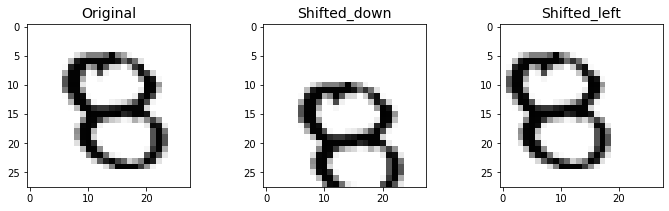

In [20]:
import matplotlib.pyplot as plt

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted_down", fontsize=14)
plt.imshow(shifted_image_down.reshape((28,28)), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted_left", fontsize=14)
plt.imshow(shifted_image_left.reshape((28,28)), interpolation="nearest", cmap="Greys")
plt.show()

In [21]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image,dx,dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [22]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [23]:
knn_clf = KNeighborsClassifier(n_neighbors=4, n_jobs=-1, weights='distance')

In [24]:
# !! takes time
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
# !! takes time
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)